If you cannot '!pip' install prophet, You should install from conda instead '!pip'

In [4]:
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from prophet import Prophet
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
plt.style.use('ggplot')

La densidad espectral Para los ARMA por medio de una función en terminos de sus polinomios de retraso para encontrar la densidad espectral.EL peridograma (transformada de furior aplicada a las autovarianzas) nos ayuda a indentificar ciclos o de qué clase son o si hay uno o más ciclos

Regresion Armonica, es una regresion de senos y cosenos, con el periodograma podemos encontrar las frecuencias que meteremos a la regresión armonica

$$
X_t = \sum_{i = 0}^{R} [ \alpha_i cos(\bar\omega_i t) + \beta_i sen(\bar\omega_i t) ] + \varepsilon_i
$$
donde 
$\bar\omega_i$ es la periodicidad y la $\alpha, \beta$ son los coeficientes armónicos y $\varepsilon$ el ruido blanco asociado

c:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


,ACF_AR(2),PACF_AR(2)
0,1.000000,1.000000
1,0.533109,0.533464
2,-0.352799,-0.891585
3,-0.824724,0.039086
4,-0.501053,0.071958
5,0.238568,-0.018600
6,0.676531,-0.038287
7,0.448007,-0.017025
8,-0.166781,-0.018856
9,-0.565003,-0.005622


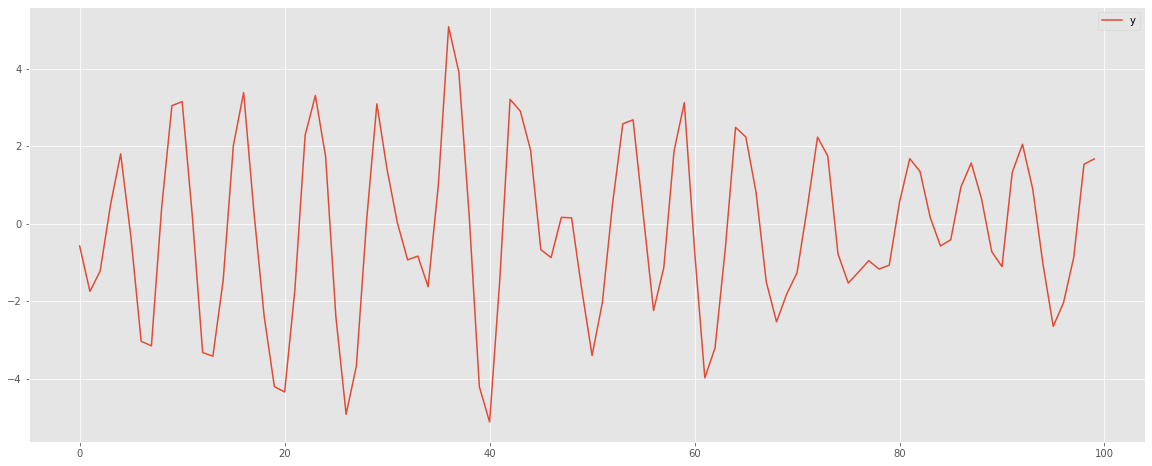

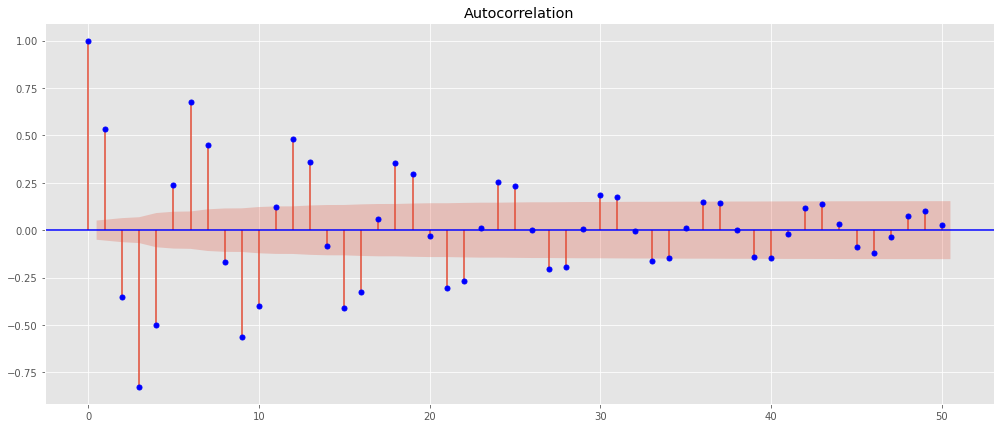

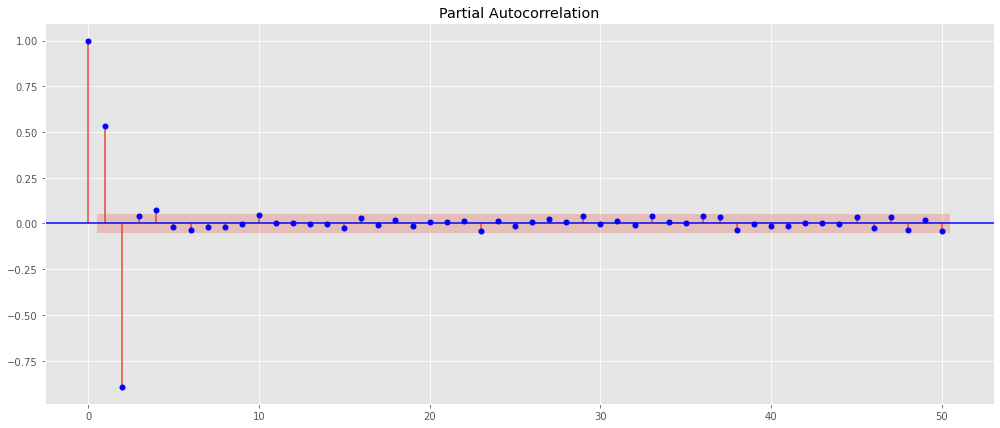

In [5]:
n = 1500
lags = 50
arparams = np.array([1, -0.9])
maparams = np.array([0.0])
ar = np.r_[1, -arparams]
ma = np.r_[1, maparams]

exogen = 'y'
# Se genera trayectoria un ARMA(2)
Xt = sm.tsa.arma_generate_sample(ar, ma, n,)
series_df = pd.DataFrame(Xt,columns= [exogen])
ar_cfs = pd.DataFrame([acf(series_df[exogen],nlags=lags),pacf(series_df[exogen],nlags=lags)])\
             .transpose()

ar_cfs.columns = ['ACF_AR(2)','PACF_AR(2)']
display(ar_cfs[:10])

plt.style.use('ggplot')
series_df.head(100).plot(figsize=(20,8))
plt.figsize=(15,10)
# autocorrelograma simple
fig = plot_acf(series_df[exogen],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
# autocorrelograma parcial
fig = plot_pacf(series_df[exogen],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
plt.show()

De la serie de tiempo podemos observar que hay una especie de ciclos cada cierto tiempo, es decir se ven valles y crestas que de manera periodica, y lo que queremos encontrar es cada cuando se repite esa oscilación. Y dado qeu creamos un AR(2), es fácil ver en el PACF dos correlaciones importantes AR(2), y ahora si vemos el ACF vemos una especie de ciclo, Sacando la transformada de Fourier de esas correlaciones es el periodograma que nos dirá cada cuando oscila la serie.

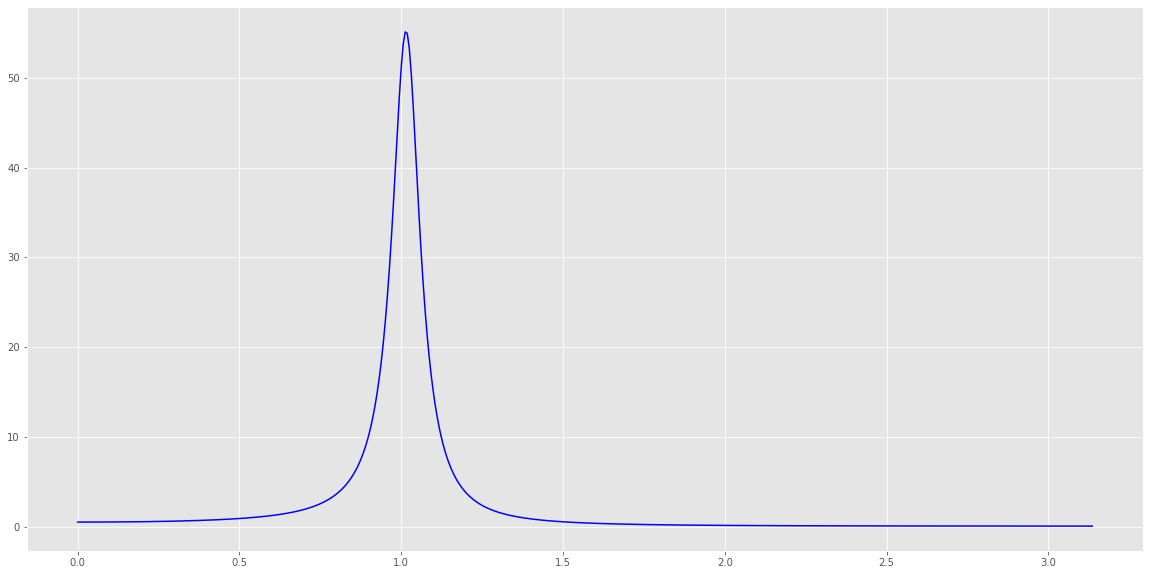

In [6]:
from statsmodels.tsa.arima_process import arma_periodogram

# Si conozco los coeficientes del modelo ajustado, se los puedo pasar a la función
# arma_periodogram() para generar la densidad espectral
freqs, density = arma_periodogram(ar, ma)
df_fw = pd.DataFrame([freqs, density]).transpose()
df_fw.columns = ['Freqs(w)','fs(w)']
plt.figure(figsize=(20,10))
plt.plot(df_fw['Freqs(w)'],df_fw['fs(w)'],color='Blue')

La imagen anterior nos dice donde se maximiza (donde está la moda), el eje x es la frecuencia, entonces 1/valor(eje x). 

(dependeiendo de las raices depende si hay o no componente estacional)

**NOTA:** lo que vemos solo es la mitad de un gráfico porque es respecto a las correlaciones  

,Freqs(w),fs_est(w),Periodo
248,0.165333,1208.584841,6.048387
247,0.164667,504.509251,6.072874
245,0.163333,399.329769,6.122449
249,0.166000,352.930452,6.024096
246,0.164000,349.299708,6.097561
238,0.158667,296.487446,6.302521
252,0.168000,285.521000,5.952381
251,0.167333,243.277549,5.976096
232,0.154667,212.015607,6.465517
237,0.158000,202.770104,6.329114


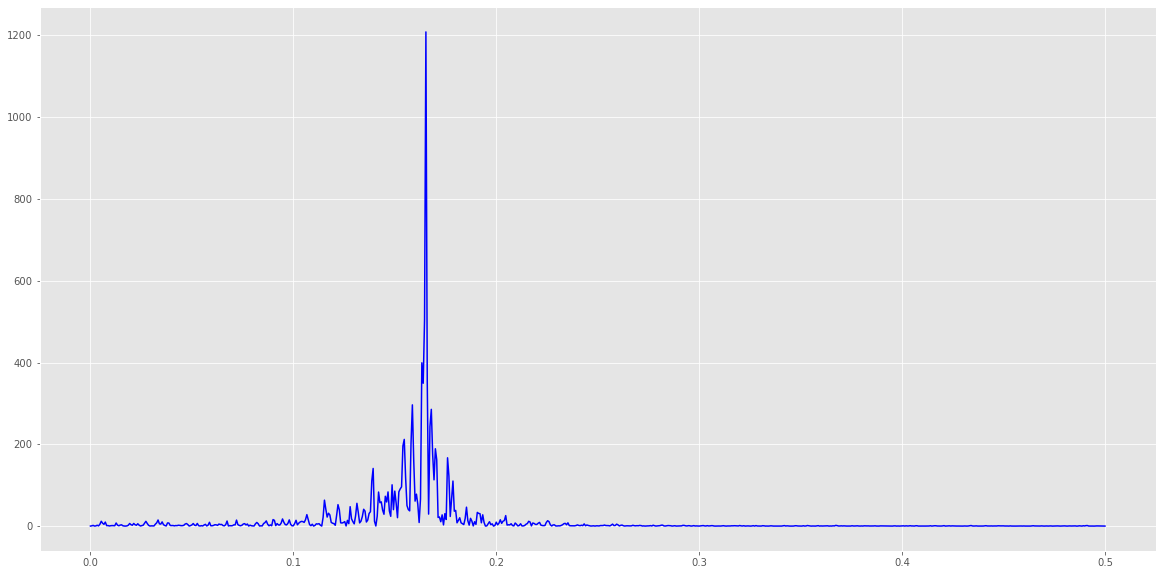

In [7]:
from scipy import signal

#otra manera de obtener el periodograma
# Periodogrma mediante la trasnformada discreta de fourier
freqs, density_est = signal.periodogram(x=series_df[exogen], scaling='density', window='hamming')
# window es la diferente función con la cual obtener el periodograma y el como
# suaviza los parametros

#el segundo arreglo de datas es la densidad espectral
# evaluada en la frecuencia
df_fw_est = pd.DataFrame([freqs, density_est]).transpose()
df_fw_est.columns = ['Freqs(w)','fs_est(w)']
plt.figure(figsize=(20,10))
plt.plot(df_fw_est['Freqs(w)'],df_fw_est['fs_est(w)'],color='Blue')
# el periodo es 1/frecuencia
df_fw_est['Periodo'] = 1/df_fw_est['Freqs(w)']
#ordenammos de mayor a menor para obtener la frecuecnias que más contribuyen
df_fw_est = df_fw_est.sort_values('fs_est(w)',ascending=False)
df_fw_est.head(15)

En la tabla podemos ver que las frecuencias que más contribuyen es el periodo de 6 (influye a la varianza de la serie), si regresaramos a la serie de tiempo, podríamos ver que cada 6 puntos hay una especie de patron 

Ahora una vez que identificamos el periodo, para la regresion armonica tenemos que meter el periodo calculado y ya solo quedaría calcular los coeficientes armonicos

Facebook prophet hace ya la regresión armonica

# Modelo con una componente importante

In [8]:
prophet_series_df = series_df.copy()
# esta paqueteria necesita forsozamente fechas es por eso que se crea 
# el soiguiente arreglo de fechas
prophet_series_df['ds'] = pd.date_range(start='2010-01-01', periods=len(prophet_series_df))
display(prophet_series_df)

prophet_model = Prophet(daily_seasonality = True)\
  .add_seasonality('componente_1', # nombre del componen, se agrega componente estacional
                   period = df_fw_est['Periodo'].values[0], #periodo, el inerso de la más significativa 
                   fourier_order = 20, #numero de iteraciones
                   # mode que sea aditiva es ver la armonica como suma de sin-cos tambien se puede como producto
                   mode ='additive')\
    .fit(prophet_series_df)

,y,ds
0,-0.579081,2010-01-01
1,-1.749738,2010-01-02
2,-1.224274,2010-01-03
3,0.468331,2010-01-04
4,1.799471,2010-01-05
...,...,...
1495,-4.032881,2014-02-04
1496,-4.284564,2014-02-05
1497,-1.085254,2014-02-06
1498,4.127839,2014-02-07


In [9]:
# 30 predicciones hacia el futuro 

#se crea df con el largo de las fechas originales + 30 a predecir
prophet_prdiction_df = pd.DataFrame(pd.date_range(start = '2010-01-01', 
                                    periods = len(prophet_series_df)+30),
                                    columns = ['ds'])

# se concatena lo real con lo predicho y en elpredict 
# concatenar es agregar columna
prophet_prdiction_df = pd.concat([prophet_model.predict(prophet_prdiction_df), series_df[['y']]],axis=1)\
                         .set_index('ds')
prophet_prdiction_df

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,componente_1,componente_1_lower,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2010-01-01,-0.470204,-1.989339,4.000216,-0.470204,-0.470204,1.578501,1.578501,1.578501,1.140207,1.140207,...,0.041692,0.041692,-0.035753,-0.035753,-0.035753,0.0,0.0,0.0,1.108297,-0.579081
2010-01-02,-0.470143,-2.418322,3.458581,-0.470143,-0.470143,0.914846,0.914846,0.914846,0.475947,0.475947,...,0.030515,0.030515,-0.023971,-0.023971,-0.023971,0.0,0.0,0.0,0.444703,-1.749738
2010-01-03,-0.470081,-3.497006,1.956775,-0.470081,-0.470081,-0.287624,-0.287624,-0.287624,-0.657062,-0.657062,...,-0.051992,-0.051992,-0.010926,-0.010926,-0.010926,0.0,0.0,0.0,-0.757705,-1.224274
2010-01-04,-0.470019,-4.364482,1.593532,-0.470019,-0.470019,-1.032392,-1.032392,-1.032392,-1.357485,-1.357485,...,-0.110285,-0.110285,0.003023,0.003023,0.003023,0.0,0.0,0.0,-1.502411,0.468331
2010-01-05,-0.469958,-3.787628,2.051837,-0.469958,-0.469958,-0.268235,-0.268235,-0.268235,-0.693916,-0.693916,...,-0.024159,-0.024159,0.017486,0.017486,0.017486,0.0,0.0,0.0,-0.738192,1.799471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-06,-0.375194,-2.448615,3.409539,-0.375194,-0.375194,0.899017,0.899017,0.899017,0.491261,0.491261,...,0.054838,0.054838,-0.079436,-0.079436,-0.079436,0.0,0.0,0.0,0.523823,NaN
2014-03-07,-0.375132,-3.787179,2.394949,-0.375132,-0.375132,-0.250276,-0.250276,-0.250276,-0.606535,-0.606535,...,0.041692,0.041692,-0.117788,-0.117788,-0.117788,0.0,0.0,0.0,-0.625408,NaN
2014-03-08,-0.375069,-4.413888,1.856222,-0.375070,-0.375069,-0.848075,-0.848075,-0.848075,-1.157151,-1.157151,...,0.030515,0.030515,-0.153794,-0.153794,-0.153794,0.0,0.0,0.0,-1.223144,NaN


<AxesSubplot:xlabel='ds'>

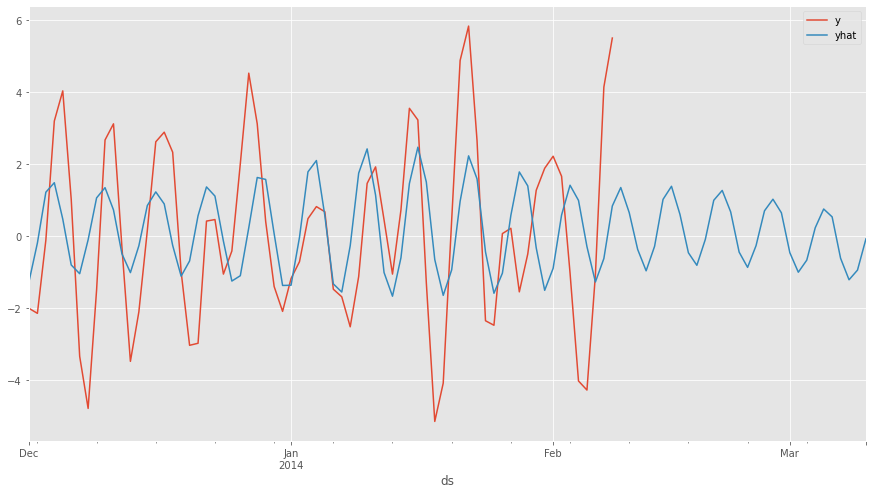

In [10]:
prophet_prdiction_df.tail(100)[['y', 'yhat',]].plot(figsize=(15,8))

# Modelo con las 5 componentes (periodos) más importantes 

In [11]:
prophet_series_df = series_df.copy()
prophet_series_df['ds'] = pd.date_range(start='2010-01-01', periods=len(prophet_series_df))
display(prophet_series_df)

#Modelo con las 5 componentes más altas del modelo
prophet_model = Prophet(daily_seasonality=True)\
  .add_seasonality('componente_1', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[0], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_2', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[1], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_3', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[2], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_4', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[3], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_5', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[4], 
                   fourier_order=20, 
                   mode='additive')\
  .fit(prophet_series_df)

,y,ds
0,-0.579081,2010-01-01
1,-1.749738,2010-01-02
2,-1.224274,2010-01-03
3,0.468331,2010-01-04
4,1.799471,2010-01-05
...,...,...
1495,-4.032881,2014-02-04
1496,-4.284564,2014-02-05
1497,-1.085254,2014-02-06
1498,4.127839,2014-02-07


<AxesSubplot:xlabel='ds'>

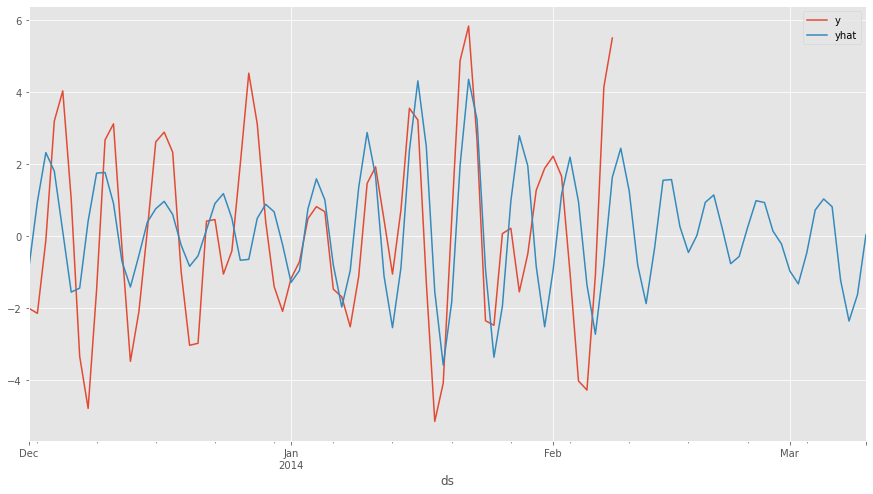

In [12]:
# 30 predicciones hacia el futuro 

#se crea df con el largo de las fechas originales + 30 a predecir
prophet_prdiction_df = pd.DataFrame(pd.date_range(start = '2010-01-01', 
                                    periods = len(prophet_series_df)+30),
                                    columns = ['ds'])

# se concatena lo real con lo predicho y en elpredict 
# concatenar es agregar columna
prophet_prdiction_df = pd.concat([prophet_model.predict(prophet_prdiction_df), series_df[['y']]],axis=1)\
                         .set_index('ds')
prophet_prdiction_df

############# Grafico
prophet_prdiction_df.tail(100)[['y', 'yhat',]].plot(figsize=(15,8))

Minetras más terminos se agreguen, más se ajustará a la serie original

In [13]:
#citytemp_df

c:\Users\jonat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3106: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ds,y
0,1995-01-01,14.277778
1,1995-01-02,13.388889
2,1995-01-03,14.222222
3,1995-01-04,14.055556
4,1995-01-05,14.888889
...,...,...
9260,2020-05-08,17.611111
9261,2020-05-09,18.666667
9262,2020-05-10,17.555556
9263,2020-05-11,17.111111


<ipython-input-14-63152f1f039e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_df['y'] = np.where(series_df['y']<=-10, series_df['y'].mean(), series_df['y'])


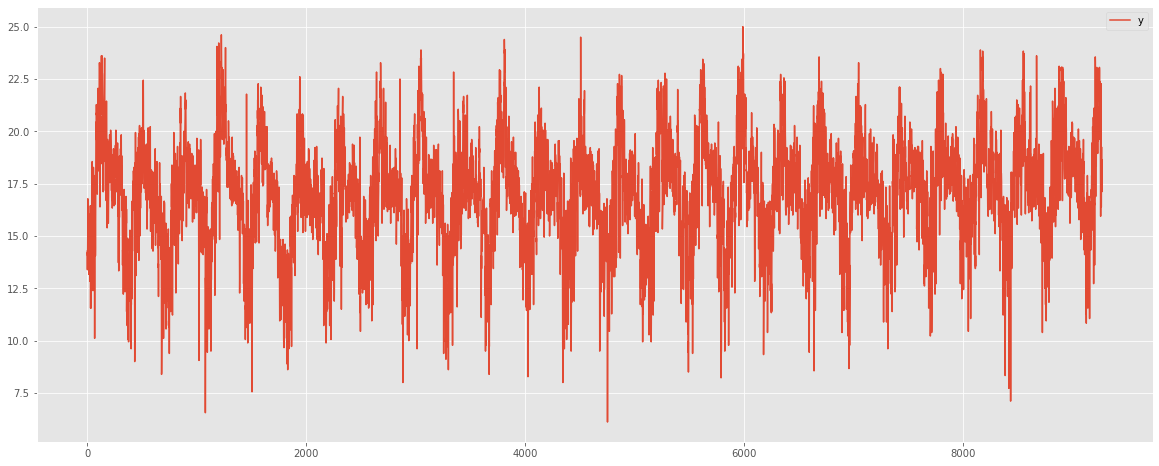

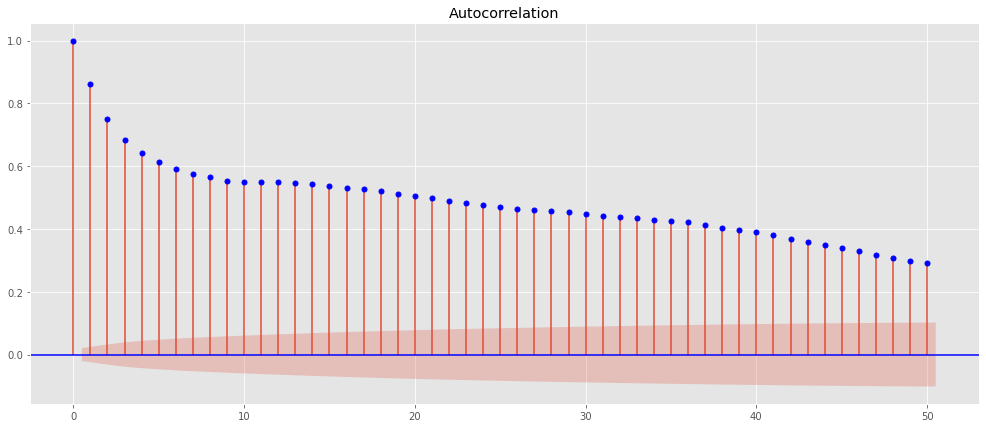

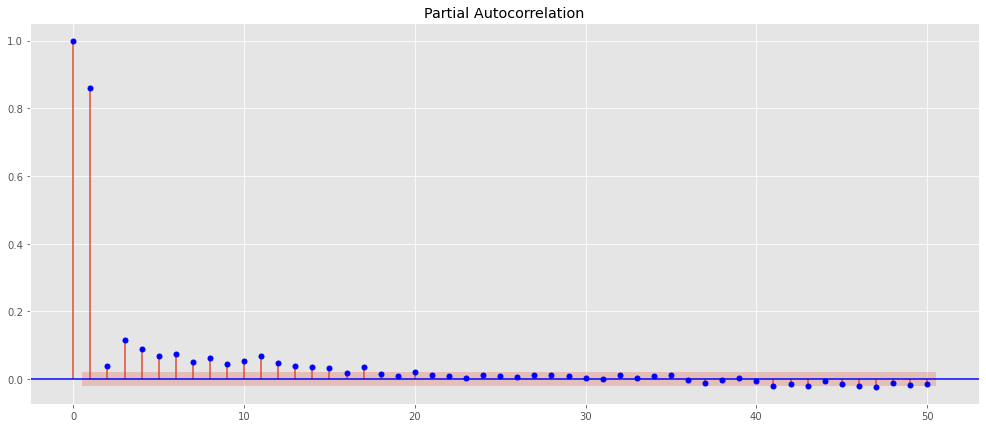

In [14]:
temperatures_df = pd.read_csv('../data/city_temperature.csv')
# filtrar el data set por país y por ciudad
citytemp_df = temperatures_df[(temperatures_df['Country']=='Mexico') &\
                              (temperatures_df['City']=='Mexico City')].copy().reset_index() #resetear el indice
 
    
# como la fecha viene toda partida, hay que unirla 
#convertir a str el año mes y dia 
citytemp_df['Year'] = citytemp_df['Year'].apply(lambda row: str(row))
citytemp_df['Month'] = citytemp_df['Month'].apply(lambda row: str(row).zfill(2)) #pegar ceros a la izquier
citytemp_df['Day'] = citytemp_df['Day'].apply(lambda row: str(row).zfill(2)) #pegar zeros a la izq

#concatenado de columnas para armar la fecha
citytemp_df['ds'] = citytemp_df['Year']+'-'+citytemp_df['Month']+'-'+citytemp_df['Day']

#pasar de temperatura fahrenhei a Celcius
citytemp_df['y'] = (5/9)*(citytemp_df['AvgTemperature']-32).copy()

#subconjunto del df copiado
series_df = citytemp_df[['ds','y']]
display(series_df)

#llenando con el promedi 
series_df['y'] = np.where(series_df['y']<=-10, series_df['y'].mean(), series_df['y'])
series_df.plot(figsize=(20,8))
plt.figsize=(15,10)
fig = plot_acf(series_df[exogen],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
fig = plot_pacf(series_df[exogen],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
plt.show()

Lo anterior sugiere aplicar un autoregresivo de un orden bastante grande, epro para este caso ajustaremos con regresion armonica

,Freqs(w),fs_est(w),Periodo
25,0.002698,15549.436399,370.600000
26,0.002806,10415.826143,356.346154
51,0.005505,3445.683353,181.666667
50,0.005397,1628.869252,185.300000
24,0.002590,687.323915,386.041667
1,0.000108,446.200449,9265.000000
27,0.002914,203.016271,343.148148
7,0.000756,201.096059,1323.571429
165,0.017809,150.963341,56.151515
4,0.000432,150.573533,2316.250000


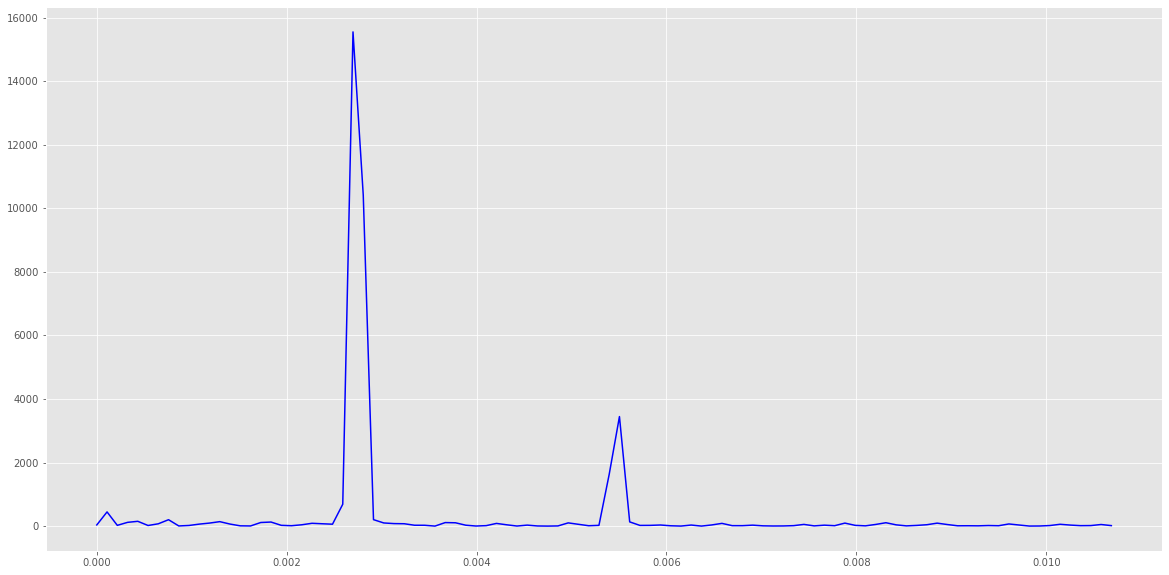

In [15]:
from scipy import signal

#calculo del periodograma con ventana ade hamming
freqs, density_est = signal.periodogram(x=series_df[exogen], scaling='density', window='hamming')
df_fw_est = pd.DataFrame([freqs, density_est]).transpose()
df_fw_est.columns = ['Freqs(w)','fs_est(w)']
plt.figure(figsize=(20,10))
plt.plot(df_fw_est['Freqs(w)'].head(100),df_fw_est['fs_est(w)'].head(100),color='Blue')
df_fw_est['Periodo'] = 1/df_fw_est['Freqs(w)']
df_fw_est = df_fw_est.sort_values('fs_est(w)',ascending=False)
df_fw_est.head(30)

Del periodograma podemos observar que hay dos periodos fuertes y si observamos detenidamente, en l atabla se observa que el peridos más fuerte es de 370 periodos, dado que la data está en días, podemos inferir que hay un ciclo anual y podemos ver un segundo periodo cada 180 dias (6 meses)

In [16]:
#modelo tomanod las primeras 5 componentes (periodos más influyentes)

prophet_series_df = series_df.copy()
# Rango dechas desde el inciio hasta donde acabe el prophet
prophet_series_df['ds'] = pd.date_range(start=series_df['ds'][0], periods=len(prophet_series_df))

prophet_model = Prophet(daily_seasonality = True)\
  .add_seasonality('componente_1', 
                   period=df_fw_est['Periodo'][0], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_2', 
                   period=df_fw_est['Periodo'][1], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_3', 
                   period=df_fw_est['Periodo'][3],
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_4', 
                   period=df_fw_est['Periodo'][4],
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_5', 
                   period=df_fw_est['Periodo'][5],
                   fourier_order=20, 
                   mode='additive')\
  .fit(prophet_series_df)

In [17]:
prophet_prdiction_df = pd.DataFrame(pd.date_range(start=series_df['ds'][0], periods=len(prophet_series_df)+365),
                                    columns=['ds'])

display(prophet_prdiction_df)

prophet_prdiction_df = pd.concat([prophet_model.predict(prophet_prdiction_df), series_df[['y']]],axis=1)\
                         .set_index('ds')
prophet_prdiction_df

,ds
0,1995-01-01
1,1995-01-02
2,1995-01-03
3,1995-01-04
4,1995-01-05
...,...
9625,2021-05-09
9626,2021-05-10
9627,2021-05-11
9628,2021-05-12


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,componente_1,componente_1_lower,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
1995-01-01,14.356687,11.335156,15.376670,14.356687,14.356687,-0.985904,-0.985904,-0.985904,1.648391,1.648391,...,-0.050933,-0.050933,-2.198362,-2.198362,-2.198362,0.0,0.0,0.0,13.370783,14.277778
1995-01-02,14.356874,11.251210,15.526691,14.356874,14.356874,-0.985764,-0.985764,-0.985764,1.648391,1.648391,...,-0.024503,-0.024503,-2.187630,-2.187630,-2.187630,0.0,0.0,0.0,13.371110,13.388889
1995-01-03,14.357060,11.171089,15.390923,14.357060,14.357060,-1.010855,-1.010855,-1.010855,1.648391,1.648391,...,-0.025830,-0.025830,-2.176477,-2.176477,-2.176477,0.0,0.0,0.0,13.346206,14.222222
1995-01-04,14.357246,11.269808,15.440935,14.357246,14.357246,-1.006844,-1.006844,-1.006844,1.648391,1.648391,...,-0.000702,-0.000702,-2.164847,-2.164847,-2.164847,0.0,0.0,0.0,13.350402,14.055556
1995-01-05,14.357433,11.300578,15.367335,14.357433,14.357433,-0.991797,-0.991797,-0.991797,1.648391,1.648391,...,0.032723,0.032723,-2.152707,-2.152707,-2.152707,0.0,0.0,0.0,13.365636,14.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-09,15.786816,18.475956,22.801294,15.786402,15.787233,4.767359,4.767359,4.767359,1.648391,1.648391,...,-0.050933,-0.050933,2.923712,2.923712,2.923712,0.0,0.0,0.0,20.554175,NaN
2021-05-10,15.786963,18.524277,22.506351,15.786545,15.787381,4.755778,4.755778,4.755778,1.648391,1.648391,...,-0.024503,-0.024503,2.937101,2.937101,2.937101,0.0,0.0,0.0,20.542741,NaN
2021-05-11,15.787110,18.352294,22.562449,15.786689,15.787530,4.717017,4.717017,4.717017,1.648391,1.648391,...,-0.025830,-0.025830,2.949260,2.949260,2.949260,0.0,0.0,0.0,20.504126,NaN


<AxesSubplot:xlabel='ds'>

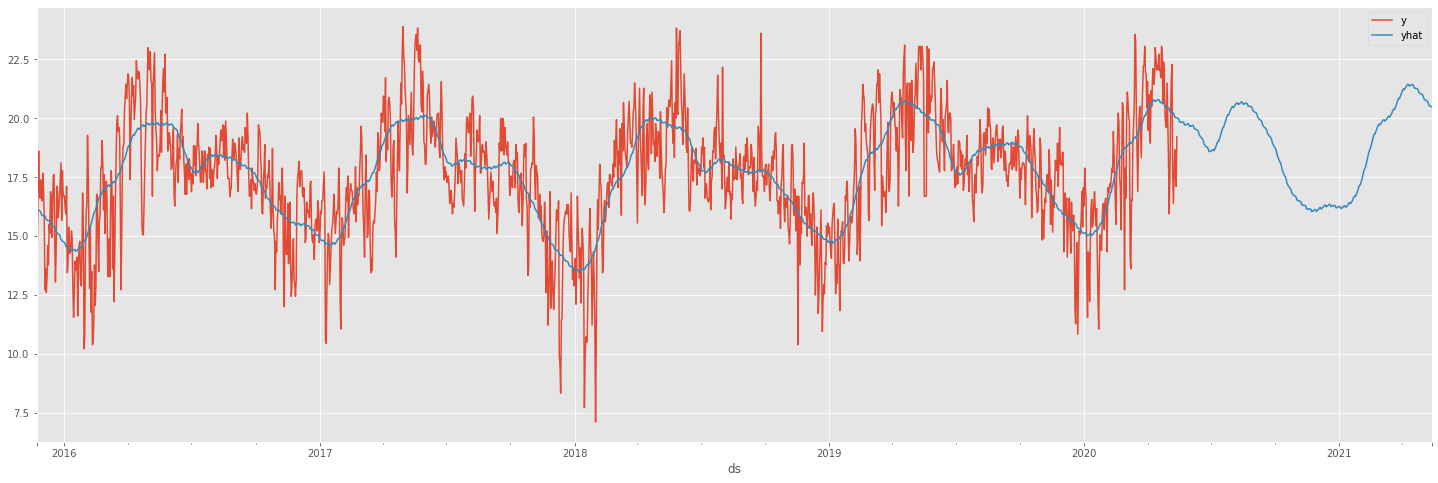

In [18]:
prophet_prdiction_df[['y', 'yhat',]].tail(2000).plot(figsize=(25,8))

Las ventajas de usar regresion armonica es que unicamente necesitamos los periodos calculados vía la transformada de fourier